In [1]:
import ratio
import numpy as np
import matplotlib.pyplot as plt

# Load packages
import json
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot
import pandas as pd
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap

#from ggplot import *
from sklearn import cluster, mixture
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from fda import *

output_notebook()

Loading BokehJS ...

In [2]:
# Various paramaters
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 15
plt.rcParams['lines.markersize'] = 4
plt.rcParams['axes.linewidth'] = 0.2
plt.rcParams['xtick.major.width'] = 0.2
plt.rcParams['ytick.major.width'] = 0.2

plt.rcParams['text.usetex'] = False
plt.rcParams['font.serif'] = "cm"

In [3]:
# Some functions
def plot_month(data, date):
    """Plot the data for one month."""
    df = data.loc[date]

    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df)
    ax.set_xlim([0, len(df)-1])
    
    plt.title(' '.join(['Manufacturing month:', date]))
    plt.xlabel('Month since manufacturing')
    plt.ylabel('Cost by vehicle')
    plt.xticks(np.arange(0, len(df), 2))
    plt.grid()
    plt.show()

def plot_months(data,length=25,title="Warranty cost",color = False, show = True):
    """Plot the data for all the months."""
    df = data.T
     
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if not color :
        ax.plot(df)
    else:
        ax.plot(df,color=color,linewidth=2)
    ax.set_xlim([0, length])
    
    plt.title(title)
    plt.xlabel('Month since manufacturing')
    plt.xticks(np.arange(0, length, 2))
    plt.ylabel('Cost per vehicle')
    plt.grid()
    return fig

def add_plot_months(data, fig):
    df = data.T
    
    ax = fig.add_subplot(111)
    ax.plot(df,color="blue",linewidth=2)
    ax.set_xlim([0, 25])
    
    plt.xlabel('Month since manufacturing')
    plt.xticks(np.arange(0, 25, 2))
    plt.ylabel('Cost per vehicle')
    plt.grid()
    plt.show()
    
def plot_coefs(data, number):
    """Plot the coefficient of a principal component through time."""
    df = data[number]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(month, df)
    
    plt.title(' '.join(['Plot of the scores of the', str(number), 'principal components']))
    plt.xlabel('Months')
    plt.xticks(rotation=45)
    plt.ylabel('Principal components scores')
    plt.grid()
    plt.show()

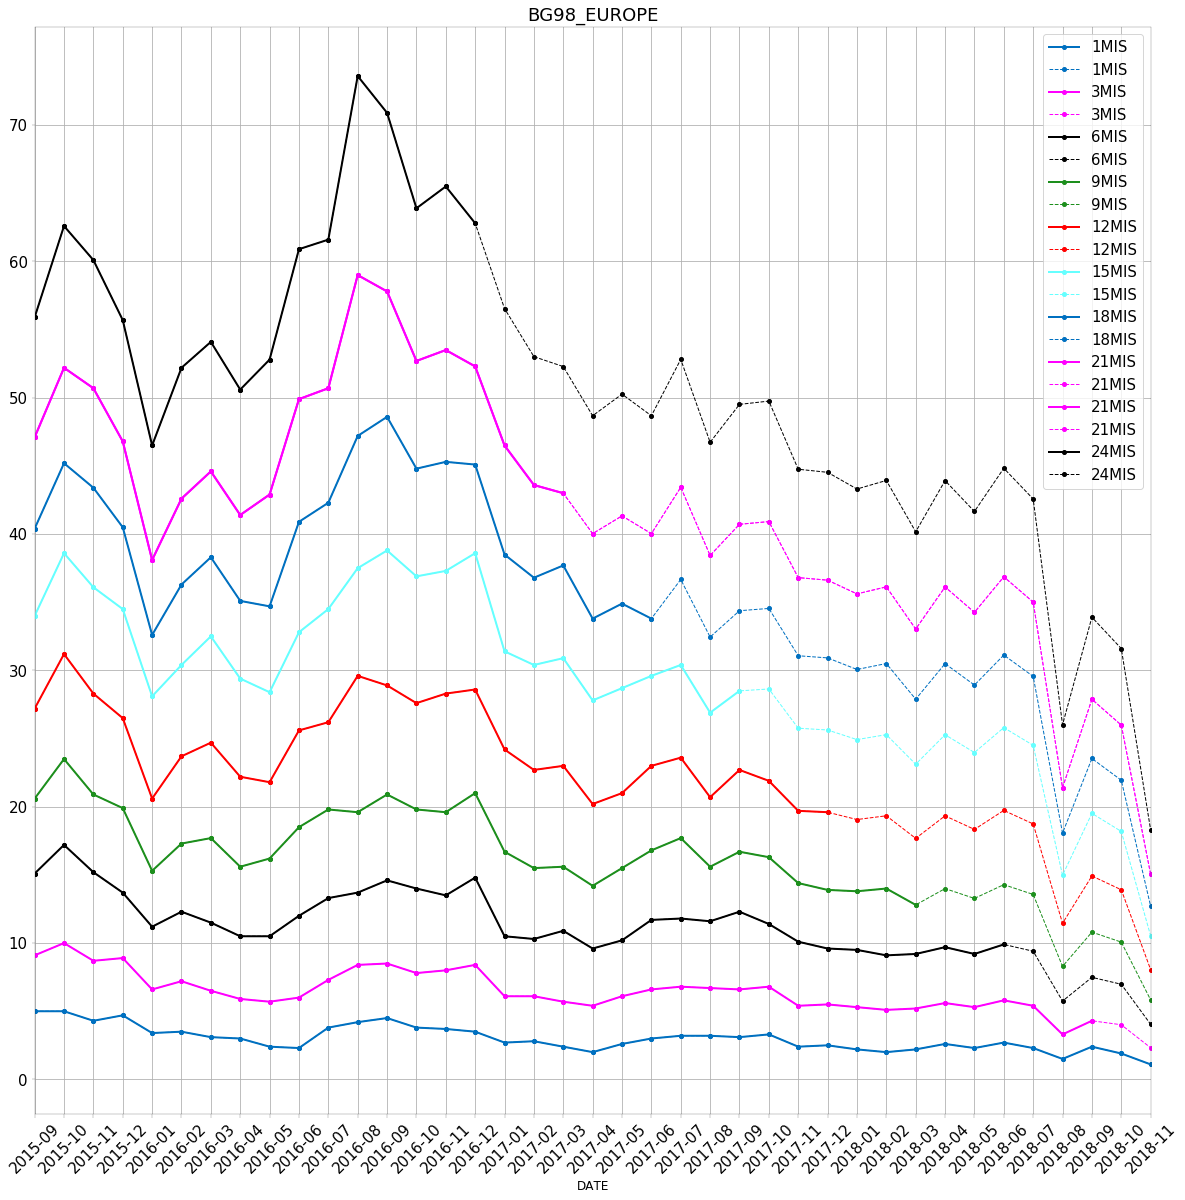

In [4]:
csvFilename = "BG98_EUROPE.csv"

r = ratio.ratioCore()

r.getData(csvFilename)
r.plotMis(["1MIS", "3MIS", "6MIS", "9MIS", "12MIS", "15MIS", "18MIS", "21MIS", "21MIS", "24MIS"])
r.calculateRatio(["21/6MIS", "21/3MIS"])

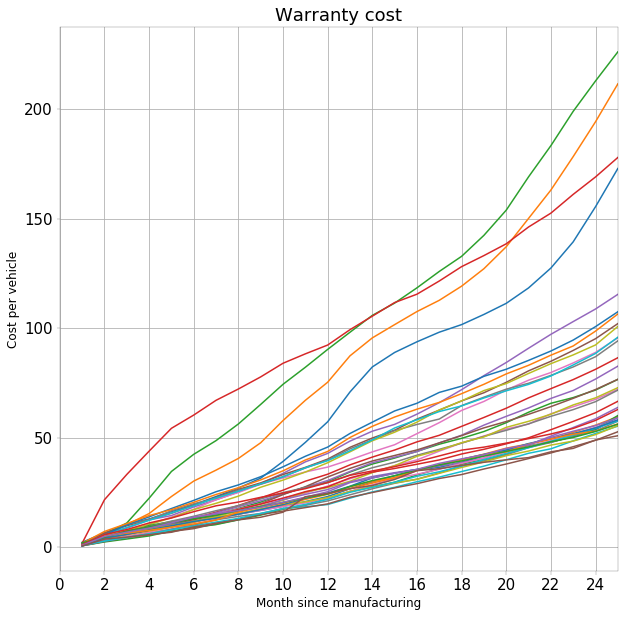

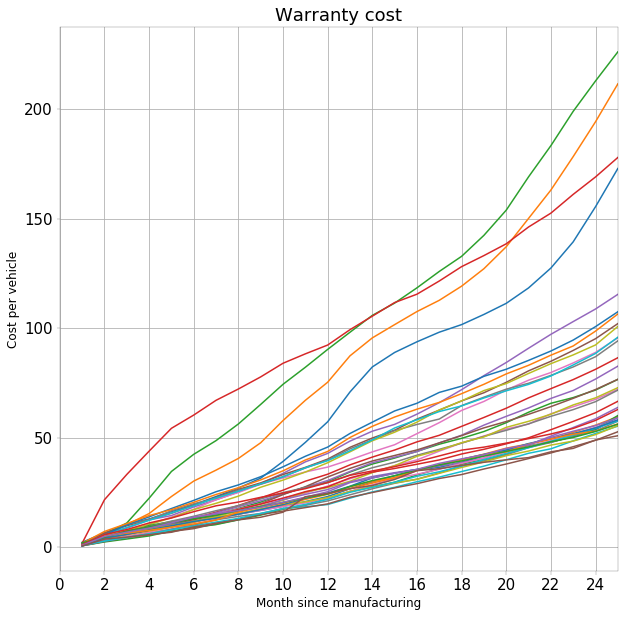

In [5]:
# Load the data
df = pd.read_csv('./B98.csv', header=None, index_col=0)
# Build the cumulative dataframe.
df_cum = df.cumsum(axis=1)
# Plot all the months (cumulative costs)
plot_months(df_cum)

In [6]:
data = r.data

mis = ["1MIS", "3MIS", "6MIS", "9MIS", "12MIS", "15MIS", "18MIS", "21MIS", "24MIS"]

cout=[]
columns=[]
for i in range(len(data)):
    month_cout=[]
    month_data = data.loc[i]

    for m in mis:   
        if(i==0):
            if(len(m)==4):
                month = int(m[0])
            elif(len(m)==5):
                month = int(m[0:2])
            columns.append(month)
        
        month_cout.append(month_data[m])
    cout.append(month_cout)

cout=np.array(cout)


df = pd.DataFrame(cout, index = data["DATE"],columns=columns)


#plot_months(df)


In [7]:
def fill_blank(df):
    #Ici on suppose qu'on a un dataFrame avec seulement 1,3,6,9 etc et on veut faire un truc linéaire 
    #pour compléter 
    data = df.values
    months = df.columns
    new_column =(data[:,1] + data[:,0])/2     

    
    data = np.concatenate((np.array([data[:,0], new_column]).T,data[:,1:]),axis=1)
    
    for i in [3,6,9,12,15,18,21]:
    
        new_column_1 = (data[:,i] - data[:,i-1])/3 + data[:,i-1]
        new_column_2 = 2*(data[:,i] - data[:,i-1])/3 + data[:,i-1]
        new_column = np.array([new_column_1, new_column_2]).T
        data = np.concatenate((data[:,:i],new_column,data[:,i:]),axis=1)

    df = pd.DataFrame(data, index = df.index,columns=np.arange(1,25))
    return df
    
df_fill = fill_blank(df)

/home/jean-baptiste/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


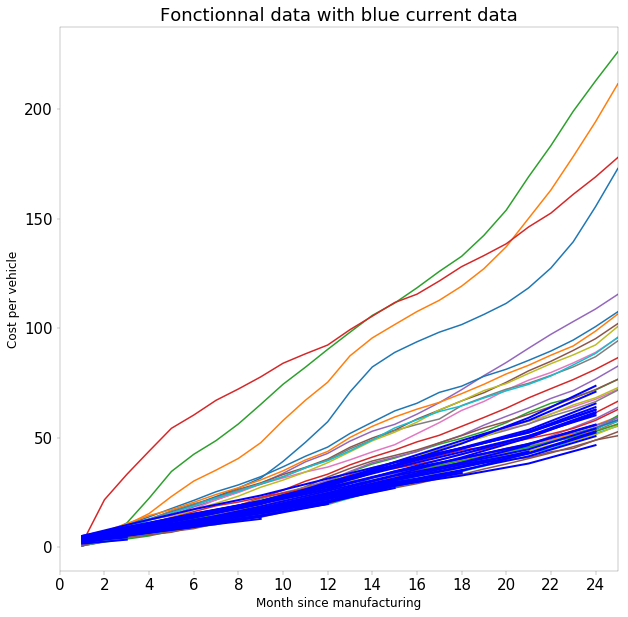

36 39
75


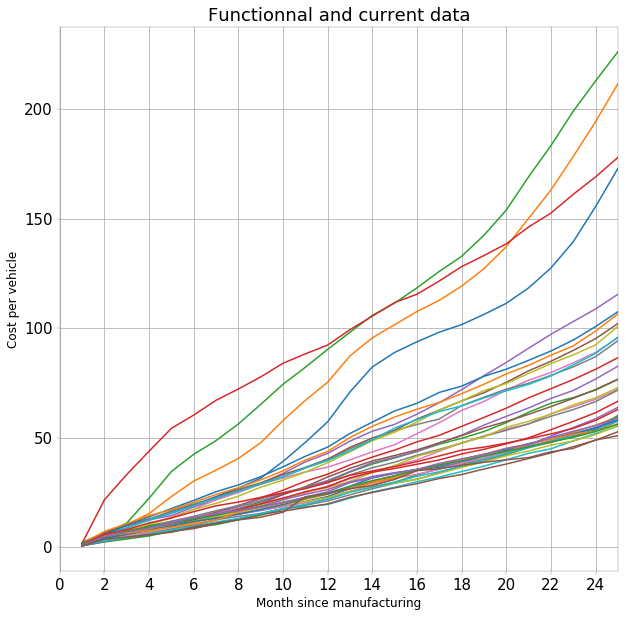

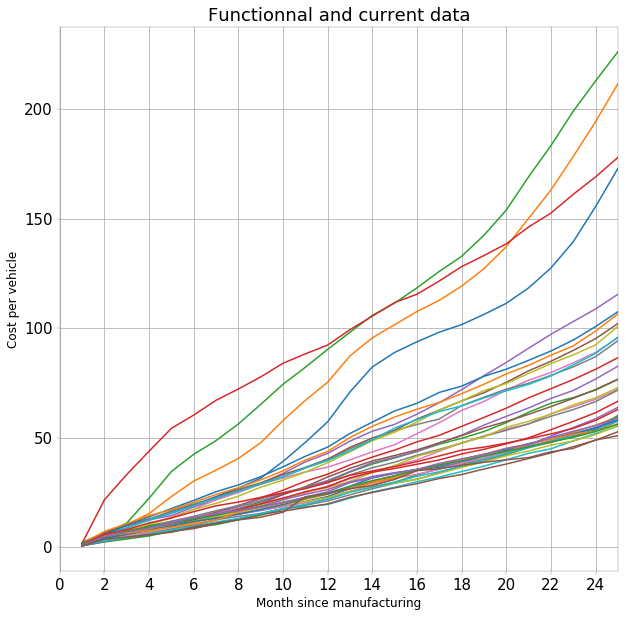

In [8]:
fig = plot_months(df_cum,title="Fonctionnal data with blue current data",show = False )
add_plot_months(df_fill, fig)
df_res = pd.concat([df_cum,df])

print(len(df_cum),len(df_fill))
print(len(df_res))

plot_months(df_res,title = "Functionnal and current data")

## PCA

In [9]:
from sklearn.decomposition import PCA

def build_pca(x):
    # calculate the PCA (Eigenvectors & Eigenvalues of the covariance matrix)
    pcaA = PCA(n_components=3, copy=True, whiten=False)

    pcaA.fit(x)
    dpca = pd.DataFrame(pcaA.transform(x))
    dpca.index = x.index
    
    for i,pc in enumerate(pcaA.explained_variance_ratio_):
        print('{0}.\t{1:2.2f}%'.format(i+1,pc*100.0))
    return pcaA

In [10]:
def plot_pca(pcaA):
    fig = plt.figure(figsize=(16,10))
    plt.title('First {0} PCA components'.format(np.shape(np.transpose(pcaA.components_))[-1]))

    plt.plot(np.transpose(pcaA.components_), label=['1. PC', '2. PC'])
    plt.legend('upper right')

    plt.show()



## Reconstruction de la courbe

In [11]:
def plot_rebuild(pcaA):
    H = []
    S = []

    for j in range(len(pcaA.components_[0])):
        H.append(j)
        s = 0
        for i in range(len(pcaA.components_)):
            s += pcaA.components_[i][j] * pcaA.singular_values_[i]
        S.append(s)
    plt.plot(H,S)
    plt.xlabel('months')
    plt.ylabel('cumulate costs')
    plt.show()
    
def plot_variance(x):
    H = []
    S = []
    for i in range(1,25):
        pcaA = PCA(n_components=i, copy=True, whiten=False)
        pcaA.fit(x)
        dpca = pd.DataFrame(pcaA.transform(x))
        dpca.index = x.index
        L = np.cumsum(pcaA.explained_variance_ratio_)
        H.append(i)
        S.append(L[-1])
    plt.plot(H,S)
    plt.xlabel('nombre de composante:')
    plt.ylabel('% de variance expliqué')
    plt.show()

1.	93.19%
2.	5.95%
3.	0.47%


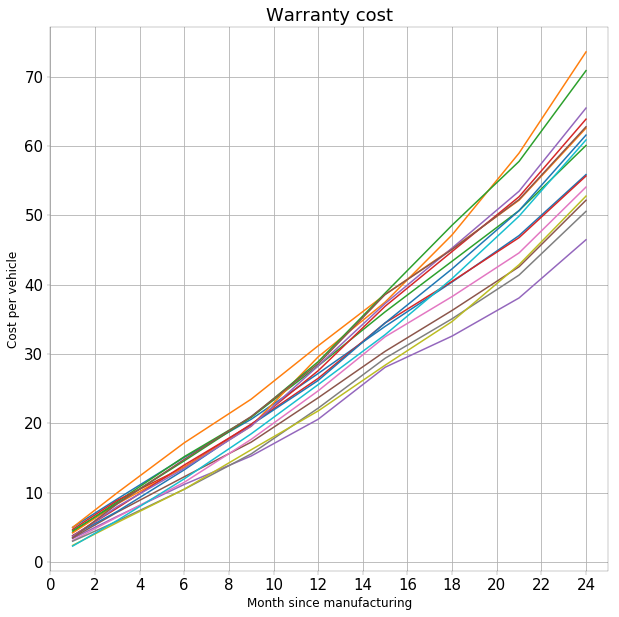

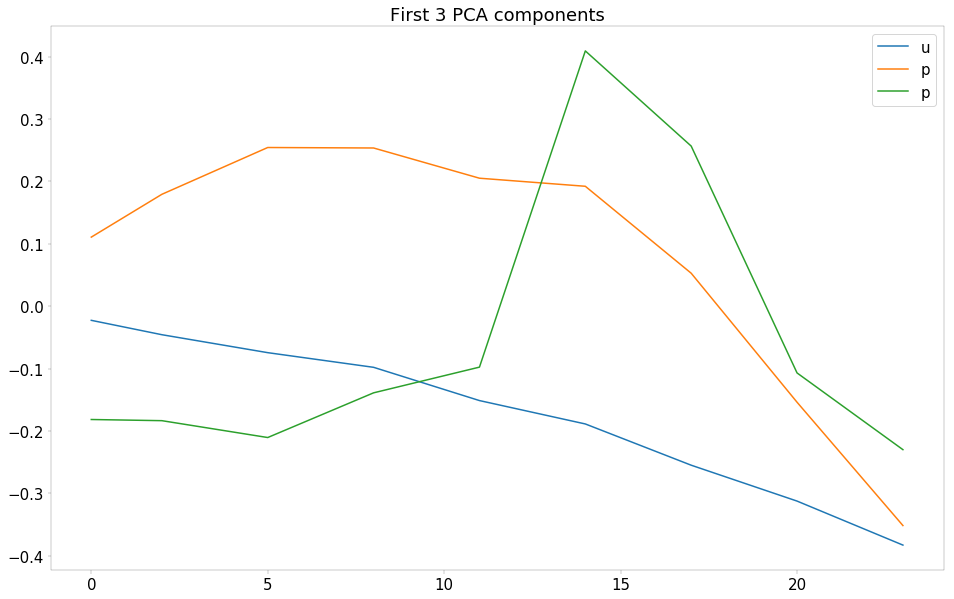

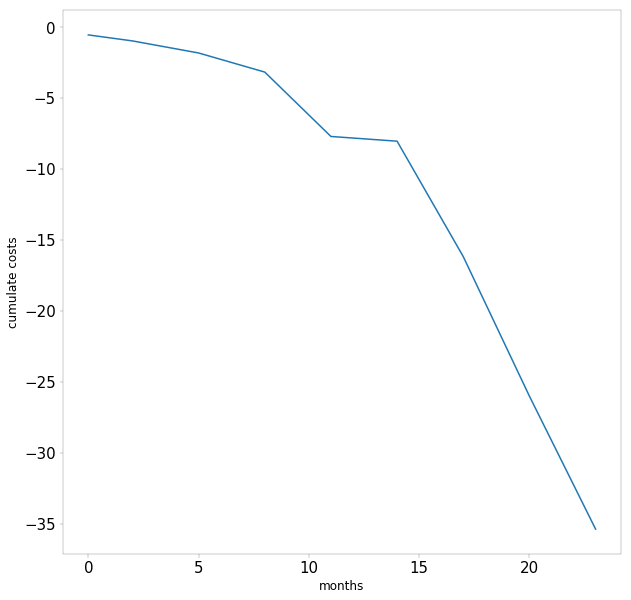

1.	98.03%
2.	1.68%
3.	0.17%


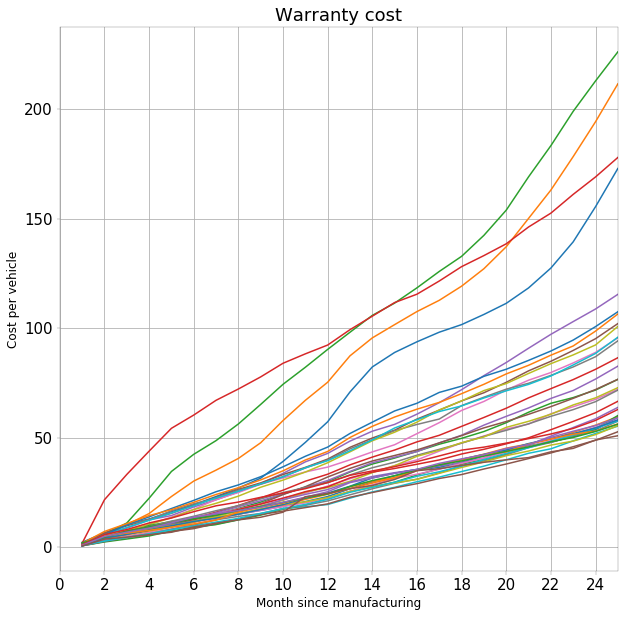

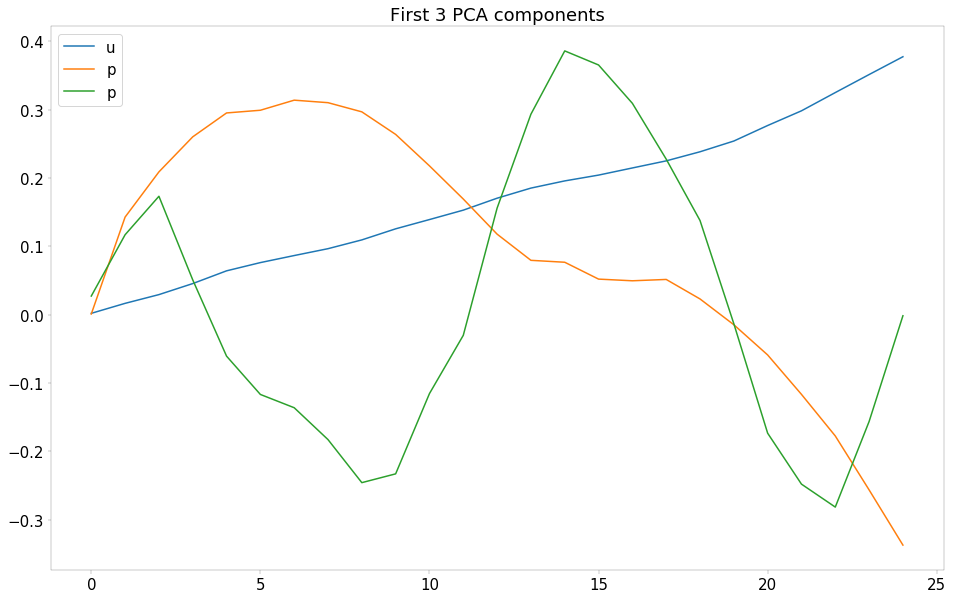

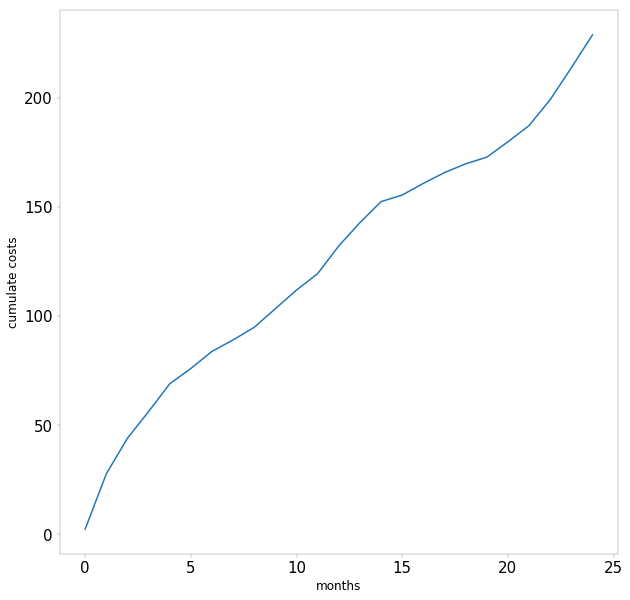

In [14]:
# x=df_cum

# pcaA = build_pca(x)
# plot_pca(pcaA)
# plot_rebuild(pcaA)

x=  df_fill.loc[:"2016-12"]


plot_months(x)

pcaA = build_pca(x)
plot_pca(pcaA)
plot_rebuild(pcaA)

x=df_cum

plot_months(x)

pcaA = build_pca(x)
plot_pca(pcaA)
plot_rebuild(pcaA)